# Heave → LSTM → FFT (fase zero) → Zero-Downcrossing

Notebook **análogo** aos anteriores, agora com **LSTM (Keras/TensorFlow)** para previsão de curto prazo da série de **heave**.

## Objetivo
- Prever **heave** com uma **LSTM** de baixa complexidade (seq→seq multi-passos);
- Aplicar **FFT** para **regularização espectral** (passa-faixa, fase zero);
- Derivar **N, Hs, Hmean, Hmax, Tz** via **zero-downcrossing**;
- Avaliar vs. **Persistência** e (opcionalmente) vs. ARIMA/ETS, usando *rolling origin* (+30, +60, +120 passos).


## Dependências
`pandas`, `numpy`, `matplotlib`, `scipy`, `tensorflow` (>=2.x), `sklearn`.

```bash
pip install pandas numpy matplotlib scipy scikit-learn tensorflow
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from numpy.fft import rfft, irfft, rfftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from typing import Tuple, Dict

plt.rcParams['figure.figsize']=(10,4)
pd.options.display.float_format = '{:.6f}'.format
tf.get_logger().setLevel('ERROR')

2025-10-21 19:22:04.497085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-21 19:22:04.510357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-21 19:22:04.516189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 19:22:04.555489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-21 19:22:05.611672: W tensorflow/compiler/tf2

## Configuração & Leitura de Dados
Esperado um CSV com colunas `timestamp` e `heave`. Ajuste caminhos e hiperparâmetros conforme sua série.

In [2]:
# === CONFIG ===
CSV_PATH = './dados/out/heave_6613_concat.csv'
TIME_COL = 'time'
VAL_COL  = 'Upward'
FREQ     = None   # ex.: 'T' se minutely; None para inferir

# Horizontes (número de passos do sampling)
HORIZONS = [5]

# Janela de entrada (lookback) e estratégia seq→seq (prevê H passos)
LOOKBACK = 256
EPOCHS   = 20
BATCH    = 64
LR       = 1e-3
PATIENCE = 3

# FFT bandpass (Hz) – ajuste após inspecionar o espectro (célula PSD)
F_MIN_HZ = 1/1000
F_MAX_HZ = 1/4

# Welch params
WELCH_WINDOW='hann'; WELCH_SEG=256; WELCH_OVERLAP=0.5

# Zero-cross limiar
HMIN = 0.0

# df = pd.read_csv(CSV_PATH)
# df[TIME_COL] = pd.to_datetime(df[TIME_COL])
# df = df.sort_values(TIME_COL).set_index(TIME_COL)
# df = df[[VAL_COL]].dropna()
# df = df.asfreq(FREQ or pd.infer_freq(df.index))
# fs = 1.0/(df.index.to_series().diff().median().total_seconds())
# print('fs (Hz):', fs)
# df.head()

In [3]:
df = pd.read_csv(CSV_PATH)
df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=False, errors='coerce')
df = df.dropna(subset=[TIME_COL, VAL_COL]).sort_values(TIME_COL).set_index(TIME_COL)
df = df[[VAL_COL]].astype(float)

# 1) tratar duplicatas (escolha UMA das políticas abaixo):

# (a) manter a primeira ocorrência
# df = df[~df.index.duplicated(keep='first')]

# (b) ou agregar duplicatas por média (recomendado para sensores)
df = df.groupby(level=0).mean()

# 2) inferir passo temporal robusto (mediana dos deltas)
dt = df.index.to_series().diff().dropna()
# se tiver timezone, remova ou padronize antes
step_seconds = dt.dt.total_seconds().median()

# opcional: se você já souber a frequência, force aqui:
if FREQ is not None:
    rule = FREQ  # ex.: 'S' segundo, 'T' minuto, '500L' 500 ms
else:
    # cria uma regra a partir do passo mediano
    # arredonda para as unidades usuais (s, ms) se fizer sentido
    from pandas.tseries.frequencies import to_offset
    rule = to_offset(pd.Timedelta(seconds=step_seconds)).freqstr

# 3) reamostrar para uma grade regular (evita problemas do asfreq com jitter)
# use .mean() (ou .nearest()) e depois complete lacunas com interpolação temporal
df = df.resample(rule).mean()

# preencher pequenas lacunas de forma segura (ajuste o limite conforme seu caso)
df[VAL_COL] = df[VAL_COL].interpolate(method='time', limit=5)  # até 5 intervalos seguidos

# 4) frequência de amostragem (Hz) a partir da grade regular
if len(df.index) >= 2:
    fs = 1.0 / (df.index[1] - df.index[0]).total_seconds()
else:
    raise ValueError("Série muito curta após o pré-processamento.")

print('Regra de reamostragem:', rule, '| fs (Hz):', fs)
df.head()


Regra de reamostragem: 160ms | fs (Hz): 6.25


,Upward
time,
2025-07-14 00:00:00.000,0.030000
2025-07-14 00:00:00.160,-0.060000
2025-07-14 00:00:00.320,-0.120000
2025-07-14 00:00:00.480,-0.140000
2025-07-14 00:00:00.640,-0.120000


## Utilitários (detrend, Welch/FFT, filtro fase-zero, zero-downcrossing, métricas)

In [4]:
def detrend_mean(x):
    x = np.asarray(x)
    return x - np.nanmean(x)

def psd_welch(x, fs, nperseg=256, noverlap=0.5, window='hann'):
    n_ov = int(nperseg*noverlap)
    f,Pxx = welch(x, fs=fs, window=window, nperseg=nperseg, noverlap=n_ov, detrend=False)
    return f,Pxx

def bandpass_fft_phase_zero(x, fs, fmin, fmax):
    x = detrend_mean(x)
    N = len(x)
    X = rfft(x)
    freqs = rfftfreq(N, d=1/fs)
    mask = (freqs>=fmin)&(freqs<=fmax)
    Xf = X*mask
    return irfft(Xf, n=N)

def zero_downcrossing(h, fs, hmin=0.0):
    h = np.asarray(h)
    N = len(h)
    idx = np.where((h[:-1]>0)&(h[1:]<=0))[0]
    if len(idx)<2:
        return dict(N=0,Hmean=np.nan,Hmax=np.nan,Hs=np.nan,Tz=np.nan)
    t = np.arange(N)/fs
    t_cross = t[idx] + (h[idx]/(h[idx]-h[idx+1]))*(1/fs)
    H_list=[]; T_list=[]
    for k in range(len(t_cross)-1):
        t0,t1 = t_cross[k], t_cross[k+1]
        i0,i1 = int(np.floor(t0*fs)), int(np.ceil(t1*fs))
        if i1<=i0+1: continue
        seg = h[i0:i1+1]
        crest = np.max(seg); trough = np.min(seg)
        H = crest - trough
        if H < hmin: continue
        H_list.append(H); T_list.append(t1-t0)
    if not H_list:
        return dict(N=0,Hmean=np.nan,Hmax=np.nan,Hs=np.nan,Tz=np.nan)
    H_arr = np.array(H_list); T_arr=np.array(T_list)
    Hmean = H_arr.mean(); Hmax=H_arr.max()
    top_n = max(1,int(np.ceil(len(H_arr)/3)))
    Hs = np.sort(H_arr)[::-1][:top_n].mean()
    Tz = T_arr.mean()
    return dict(N=len(H_arr), Hmean=Hmean, Hmax=Hmax, Hs=Hs, Tz=Tz)

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred=np.asarray(y_pred)
    e = y_pred - y_true
    rmse = float(np.sqrt(np.mean(e**2)))
    mae  = float(np.mean(np.abs(e)))
    smape = float(np.mean(2*np.abs(e)/np.where((np.abs(y_true)+np.abs(y_pred))==0,1,(np.abs(y_true)+np.abs(y_pred)))))
    return dict(RMSE=rmse, MAE=mae, sMAPE=smape)

## Preparação de dados para LSTM (janelas seq→seq)

In [5]:
def make_windows(y: np.ndarray, lookback: int, horizon: int):
    X, Y = [], []
    for i in range(len(y)-lookback-horizon+1):
        X.append(y[i:i+lookback])
        Y.append(y[i+lookback:i+lookback+horizon])
    X = np.array(X)[:, :, None]  # (N, lookback, 1)
    Y = np.array(Y)              # (N, horizon)
    return X, Y

def build_lstm(lookback: int, horizon: int, lr: float=1e-3):
    inp = layers.Input(shape=(lookback,1))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.LSTM(32)(x)
    out = layers.Dense(horizon)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])
    return model

## Rolling Origin com LSTM
Treina uma LSTM por corte (treino curto) e prevê **H** passos; aplica FFT fase-zero e zero-downcrossing.

In [6]:
from collections import defaultdict

def rolling_origin_lstm(df, val_col, horizons, fs,
                        lookback=256, epochs=20, batch=64, lr=1e-3, patience=3,
                        train_min_points=1500,
                        fmin=1/1000, fmax=1/4, hmin=0.0):
    y = df[val_col].astype(float).values
    scaler = StandardScaler()
    res_rows=[]
    for cut in range(train_min_points, train_min_points+11):
    #for cut in range(train_min_points, len(y)-max(horizons)-1):
        y_train = y[:cut]
        for H in horizons:
            y_true = y[cut:cut+H]
            # normaliza por treino
            y_train_sc = scaler.fit_transform(y_train.reshape(-1,1)).ravel()
            Xtr, Ytr = make_windows(y_train_sc, lookback, H)
            if len(Xtr)==0:
                continue
            model = build_lstm(lookback, H, lr)
            es = callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
            model.fit(Xtr, Ytr, epochs=epochs, batch_size=batch, verbose=0, validation_split=0.1, callbacks=[es])

            # entrada: última janela do treino (normalizada)
            x_last = y_train_sc[-lookback:][None,:,None]
            y_pred_sc = model.predict(x_last, verbose=0)[0]
            # desscala previsão
            y_pred = scaler.inverse_transform(y_pred_sc.reshape(-1,1)).ravel()

            # baseline persistência
            y_pers = np.repeat(y_train[-1], H)

            # filtragem FFT fase-zero
            y_true_f = bandpass_fft_phase_zero(y_true, fs, fmin, fmax)
            y_pred_f = bandpass_fft_phase_zero(y_pred, fs, fmin, fmax)
            y_pers_f = bandpass_fft_phase_zero(y_pers, fs, fmin, fmax)

            # métricas heave
            m_lstm = metrics(y_true, y_pred)
            m_pers = metrics(y_true, y_pers)

            # parâmetros
            w_true = zero_downcrossing(y_true_f, fs, hmin)
            w_lstm = zero_downcrossing(y_pred_f, fs, hmin)
            w_pers = zero_downcrossing(y_pers_f, fs, hmin)

            for name, m, w in [('LSTM', m_lstm, w_lstm), ('Persistence', m_pers, w_pers)]:
                res_rows.append({
                    'cut_idx':cut, 'horizon':H, 'model':name,
                    'RMSE':m['RMSE'], 'MAE':m['MAE'], 'sMAPE':m['sMAPE'],
                    'N_true':w_true.get('N'), 'Hmean_true':w_true.get('Hmean'), 'Hmax_true':w_true.get('Hmax'), 'Hs_true':w_true.get('Hs'), 'Tz_true':w_true.get('Tz'),
                    'N_pred':w.get('N'), 'Hmean_pred':w.get('Hmean'), 'Hmax_pred':w.get('Hmax'), 'Hs_pred':w.get('Hs'), 'Tz_pred':w.get('Tz'),
                })
    return pd.DataFrame(res_rows)

### Rodar (ajuste `train_min_points`, `LOOKBACK`, `EPOCHS` conforme seu dataset)

In [7]:
df_res_lstm = rolling_origin_lstm(
    df, VAL_COL, HORIZONS, fs,
    lookback=LOOKBACK, epochs=EPOCHS, batch=BATCH, lr=LR, patience=PATIENCE,
    train_min_points=1500,
    fmin=F_MIN_HZ, fmax=F_MAX_HZ, hmin=HMIN
)
df_res_lstm.head()

,cut_idx,horizon,model,RMSE,MAE,sMAPE,N_true,Hmean_true,Hmax_true,Hs_true,Tz_true,N_pred,Hmean_pred,Hmax_pred,Hs_pred,Tz_pred
0,1500,5,LSTM,0.199203,0.198435,1.257939,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,1500,5,Persistence,0.163585,0.160000,0.878459,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2,1501,5,LSTM,0.109196,0.107088,0.579472,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
3,1501,5,Persistence,0.063087,0.058000,0.245161,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
4,1502,5,LSTM,0.073945,0.070100,0.420340,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


## Sumário de métricas (heave e parâmetros)

In [8]:
def relerr(true, pred):
    return 100.0*(np.asarray(pred)-np.asarray(true))/np.where(np.asarray(true)==0, np.nan, np.asarray(true))

def summarize(df_res):
    out=[]
    for (H, model), g in df_res.groupby(['horizon','model']):
        hs_rel = relerr(g['Hs_true'], g['Hs_pred'])
        tz_rel = relerr(g['Tz_true'], g['Tz_pred'])
        out.append({'horizon':H,'model':model,
                    'RMSE':g['RMSE'].mean(), 'MAE':g['MAE'].mean(), 'sMAPE':g['sMAPE'].mean(),
                    'Hs_relerr_pct_mean':np.nanmean(hs_rel), 'Tz_relerr_pct_mean':np.nanmean(tz_rel)})
    return pd.DataFrame(out)

summary_lstm = summarize(df_res_lstm)
summary_lstm.sort_values(['horizon','model'])

/tmp/ipykernel_476324/2543633532.py:11: RuntimeWarning: Mean of empty slice
  'Hs_relerr_pct_mean':np.nanmean(hs_rel), 'Tz_relerr_pct_mean':np.nanmean(tz_rel)})


,horizon,model,RMSE,MAE,sMAPE,Hs_relerr_pct_mean,Tz_relerr_pct_mean
0,5,LSTM,0.125729,0.115452,0.934251,NaN,NaN
1,5,Persistence,0.185853,0.167273,1.087912,NaN,NaN


## PSD (Welch) para ajuste de banda

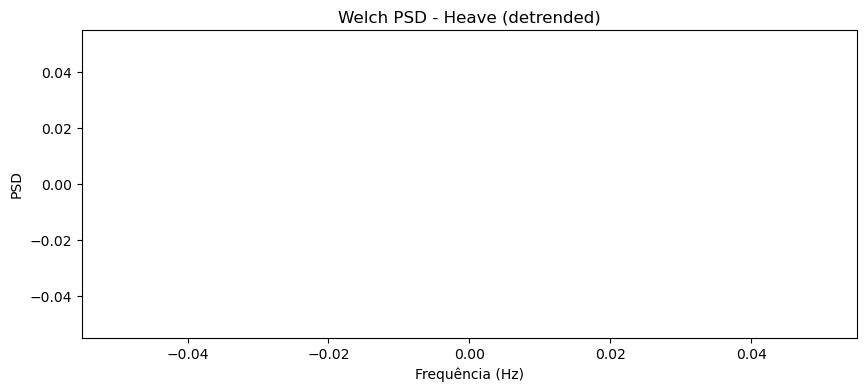

In [9]:
x = df[VAL_COL].astype(float).values
x_d = detrend_mean(x)
f_psd, Pxx = psd_welch(x_d, fs, nperseg=WELCH_SEG, noverlap=WELCH_OVERLAP, window=WELCH_WINDOW)
plt.plot(f_psd, Pxx)
plt.xlabel('Frequência (Hz)'); plt.ylabel('PSD'); plt.title('Welch PSD - Heave (detrended)'); plt.show()

## Exportar resultados (CSV)

In [10]:
from pathlib import Path
outdir = Path('./outputs_lstm')
outdir.mkdir(parents=True, exist_ok=True)
df_res_lstm.to_csv(outdir/'rolling_results_lstm.csv', index=False)
summary_lstm.to_csv(outdir/'summary_metrics_lstm.csv', index=False)
print('Arquivos salvos em', outdir.resolve())

Arquivos salvos em /extra0/home/myarqs/Documentos/atmosmarine/projetos/sophia-wv/outputs_lstm


## Notas
- A LSTM é **leve** (64→32 unidades). Ajuste LOOKBACK, camadas e regularização para seu dataset.
- Use **EarlyStopping** para evitar *overfitting*; reduza EPOCHS se for rodar em tempo de operação.
- A normalização é **reajustada** em cada corte usando apenas dados de treino (evita *leakage*).
- Mantemos **fase zero** na filtragem por máscara simétrica em FFT antes do zero-crossing.

## Referências (ABNT)
- HOLTHUIJSEN, L. H. **Waves in Oceanic and Coastal Waters**. Cambridge University Press, 2007.
- GODA, Y. **Random Seas and Design of Maritime Structures**. World Scientific, 2010.
- OPPENHEIM, A. V.; SCHAFER, R. W. **Discrete-Time Signal Processing**. Prentice Hall, 2010.
- GOODFELLOW, I.; BENGIO, Y.; COURVILLE, A. **Deep Learning**. MIT Press, 2016 (cap. RNNs).
- HYNDMAN, R. J.; ATHANASOPOULOS, G. **Forecasting: Principles and Practice** (cap. redes neurais para previsão), 2021.
